In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *

In [3]:
import os
path_to_data = Path('data')
path_to_data.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

In [12]:
#Unzip file downloaded from kaggle website
import zipfile
with zipfile.ZipFile(str(path_to_data)+"/train.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)
    
with zipfile.ZipFile(str(path_to_data)+"/test.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)

with zipfile.ZipFile(str(path_to_data)+"/test_labels.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)

In [4]:
path_to_data.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

## Data

In [6]:
df = pd.read_csv(str(path_to_data) + "/train.csv")

In [15]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Language Model

In [4]:
path = Path(path_to_data)
path.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

In [5]:
#Batch size
bs=24

In [9]:
#Create a databunch for our Language Model
data_lm = (TextList.from_df(df, cols=1).split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)) 

In [19]:
data_lm.save(str(path) + '/data_lm.pkl')

In [6]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch(5)

idx,text
0,". xxmaj he seems to care more about the formatting than the actual info . xxbos "" \n xxmaj more \n i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of "" "" types of accidents "" "" xxup -i think the references may need tidying so that they are all in the"
1,"in place . xxmaj makes me feel real good about your judgement in xxunk me . xxmaj sorta . xxmaj everyme "" xxbos "" \n i am gratified that you have truthfully explained your assumptions of bad faith . i dislike dishonesty more than most . i endeavor to keep xxmaj the xxmaj big xxmaj boys honest , which includes you since you immigrated over here , so do"
2,"xxmaj thank you , best wishes . xxbos "" \n \n xxmaj gatherer xxmaj code \n \n xxmaj there is another internal to xxup xxunk code for each set . xxmaj the code is used in "" "" xxmaj gatherer "" "" when an expansion set is chosen in the advanced search . xxmaj sometimes these codes match up to the internal code that is already here but"
3,"xxunk "" "" . xxmaj my goal was to add some more description to what hoodoo is by discussing some of the underlying symbolism and worldview . i 'm missing a quote that i have n't been able to track down , in xxmaj hyatt 's book vol 1 xxmaj hoodoo - xxmaj xxunk and xxunk , there is an xxunk who says something along the lines of , """
4,"n't consensus to delete at that point . ) ✽ \n \n "" xxbos xxmaj xxunk ] ] 19:02 , 3 xxmaj jan 2004 ( xxup utc ) xxbos "" \n \n xxup prep vs. xxmaj quick xxmaj count \n \n xxmaj the text of the article suggests ( and states overtly at least once ) that the xxup prep and the xxmaj quick xxmaj count are"


In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [23]:
learn.lr_find(num_it=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


With suggestion=True in learn.recorder.plot, we will see the point where the gardient is the steepest

Min numerical gradient: 2.29E-02
Min loss divided by 10: 6.92E-03


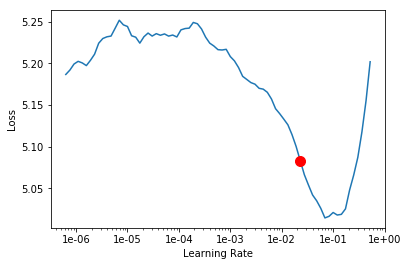

In [24]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [25]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.022908676527677745

In [26]:
learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.320640,4.114595,0.309839,47:33


In [27]:
learn.save('fit_head')

In [28]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(5, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.425241,4.394435,0.287190,54:20
1,4.378030,4.321069,0.295596,54:19
2,4.116281,4.167389,0.311328,54:23
3,3.979223,3.966848,0.334828,54:22
4,3.956095,3.866158,0.348071,54:23


In [31]:
learn.save('fine_tuned')

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state.

In [32]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [7]:
valid_test = pd.read_csv(str(path) + '/test.csv')

test_datalist = TextList.from_df(valid_test, cols='comment_text', vocab=data_lm.vocab)

In [8]:
data_clas = TextList.from_csv(path, 'train.csv', cols='comment_text', vocab=data_lm.vocab)\
                .split_by_rand_pct(0.1)

In [9]:
data_clas = data_clas.label_from_df(cols=['toxic', 'severe_toxic', 'obscene', 'threat',  'insult', 'identity_hate'])

In [10]:
data_clas = data_clas.add_test(test_datalist)

In [11]:
data_clas = data_clas.databunch(bs=bs)

In [12]:
data_clas.show_batch(5)

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos i xxup own xxup this xxup page xxup you xxup fools ! ! xxup you xxup should xxup fear xxup me xxrep 8 ! i xxup am xxup the xxup god xxup of xxup chocobos , i xxup want xxup my xxup cheese , xxup george xxup bush xxup should xxup go xxup to xxup hell xxrep 9 ! i xxup am xxup the xxup god xxup of xxup",toxic;insult
"xxbos xxmaj some enjoyable reading for a giant from xxmaj montenegro \n \n xxmaj les xxmaj alpes xxmaj dinariques un xxunk de xxunk de grande taille \n xxmaj jean - xxmaj claude xxmaj pineau xxunk , xxmaj paul xxmaj xxunk b , xxmaj stipe xxmaj xxunk c \n a « xxmaj xxunk de xxunk xxunk » , xxup xxunk , xxup xxunk xxunk , 44 , rue",
"xxbos "" \n \n xxmaj assume xxmaj good xxmaj faith xxmaj does xxmaj not xxmaj mean xxmaj have xxmaj blind xxmaj faith xxmaj despite the xxmaj facts \n \n xxmaj by repeatedly for months citing a book published by xxmaj st. xxmaj martin 's xxmaj press ( xxmaj new xxmaj york ) , "" "" xxmaj feeling xxmaj your xxmaj pain , "" "" as a source of",
"xxbos "" \n \n xxmaj first i 'm a little obsessive with unfounded criticism . xxmaj sorry about that , xxmaj it makes me long - winded . i 'm not at all xxunk with this xxunk which i could give two deuces xxunk once it is properly sourced and defined . \n \n xxmaj user : xxmaj brangifer has a lot to say about me . xxmaj",


In [13]:
data_clas.save('data_clas.pkl')

In [14]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [15]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [16]:
learn.freeze()

In [31]:
#Check the number of labels
data_clas.c

6

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.51E-02


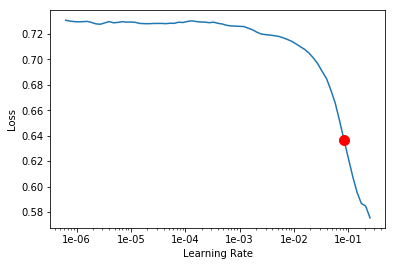

In [33]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [34]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.08317637711026708

In [35]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.093102,1.029371,33:53


In [36]:
learn.save('classifier')

In [28]:
learn.load('classifier')
learn.show_results()

text,target,prediction
xxbos i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup,toxic,
xxbos ' ' ' xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj fuck xxmaj you ! xxmaj,toxic;severe_toxic;obscene,
xxbos xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup hate xxup you xxup,toxic;insult,toxic
"xxbos "" \n \n \n xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup",toxic,
"xxbos "" ( ) you are xxup such a fucking twat flap \n \n xxmaj position / / xxmaj artist , xxmaj band , or xxmaj group / / xxmaj song xxmaj title / / xxmaj weeks xxmaj spent xxmaj at # 1 / / xxmaj year \n \n 1 . xxmaj mariah xxmaj carey & xxmaj boyz xxup ii xxmaj men- "" "" xxmaj one xxmaj sweet",toxic,


## Evaluate results

In [17]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [29]:
# Predict on the validation dataset
y_pred, y_true = learn.get_preds()

In [30]:
f1_score(y_true, y_pred>0.35, average='micro')

0.21945447751899363

In [31]:
y_test = y_true.numpy()
scores = y_pred.numpy()

In [32]:
scores.shape, y_test.shape

((15957, 6), (15957, 6))

In [33]:
scores

array([[0.02464 , 0.000589, 0.007912, 0.000476, 0.008848, 0.002182],
       [0.063868, 0.002264, 0.024451, 0.002238, 0.025134, 0.00563 ],
       [0.121621, 0.005419, 0.038581, 0.004594, 0.054087, 0.010349],
       [0.042149, 0.001497, 0.014764, 0.001813, 0.017297, 0.003968],
       ...,
       [0.030155, 0.000885, 0.01105 , 0.001232, 0.012264, 0.002411],
       [0.241976, 0.007878, 0.103528, 0.003796, 0.087144, 0.012358],
       [0.098997, 0.003783, 0.035001, 0.00287 , 0.039473, 0.007543],
       [0.183797, 0.009991, 0.063906, 0.00787 , 0.083622, 0.015485]], dtype=float32)

In [34]:
y_test

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [35]:
metrics = classification_report(y_test, scores>0.85, target_names=data_clas.valid_ds.classes)
print(metrics)

               precision    recall  f1-score   support

        toxic       0.18      0.10      0.13      1570
 severe_toxic       0.20      0.11      0.14       148
      obscene       0.20      0.15      0.17       828
       threat       0.00      0.00      0.00        49
       insult       0.33      0.11      0.16       773
identity_hate       0.02      0.01      0.01       133

    micro avg       0.20      0.11      0.14      3501
    macro avg       0.15      0.08      0.10      3501
 weighted avg       0.21      0.11      0.14      3501
  samples avg       0.01      0.01      0.01      3501



/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
micro_roc_auc_ovo = roc_auc_score(y_test, scores, multi_class="ovo",
                                  average="micro")
micro_roc_auc_ovo

0.8549673215018959

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

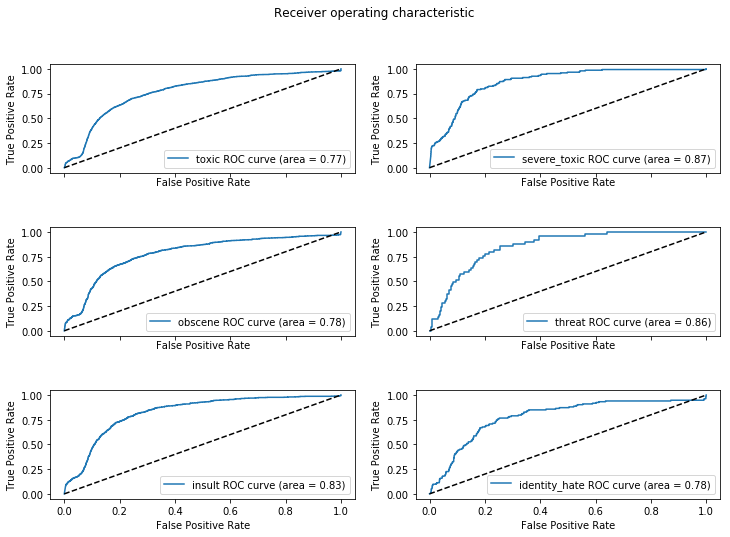

In [38]:
# Plot of a ROC curve for a specific class
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(12, 8))
fig.subplots_adjust(hspace=.5)
fig.suptitle('Receiver operating characteristic')

i=0
axs[0, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[0, 0].plot([0, 1], [0, 1], 'k--')
axs[0, 0].legend(loc="lower right")

i=1
axs[0, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[0, 1].plot([0, 1], [0, 1], 'k--')
axs[0, 1].legend(loc="lower right")

i=2
axs[1, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[1, 0].plot([0, 1], [0, 1], 'k--')
axs[1, 0].legend(loc="lower right")

i=3
axs[1, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[1, 1].plot([0, 1], [0, 1], 'k--')
axs[1, 1].legend(loc="lower right")

i=4
axs[2, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[2, 0].plot([0, 1], [0, 1], 'k--')
axs[2, 0].legend(loc="lower right")

i=5
axs[2, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[2, 1].plot([0, 1], [0, 1], 'k--')
axs[2, 1].legend(loc="lower right")

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

plt.show()
